In [3]:
# !pip install  tensorflow upgrade

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io as sio
from tensorflow.random import set_seed
from ipywidgets import interact   #interactive plot
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
#######################################
#define the activation function
def rbf(x):
    return tf.math.exp(-x**2)

#######################################
#define the derivative of the activation function
def d_rbf(x):
    return tf.gradients(rbf,x)

#######################a################
#we couldn't use “tf_d_leaky_relu_6” as an activation function if we wanted to 
#because tensorflow doesn't know how to calculate the gradients of that function.
def rbf_grad(op, grad):
    x = op.inputs[0]
    n_gr = d_rbf(x)    #defining the gradient.
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
#     with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def tf_rbf(x,name=None):
    with tf.name_scope(name, "rbf", [x]) as name:
        y = py_func(rbf,   #forward pass function
                    [x],
                    [tf.float32],
                    name=name,
                    grad= rbf_grad) #the function that overrides gradient
        y[0].set_shape(x.get_shape())     #when using with the code, it is used to specify the rank of the input.
    return y[0]

In [27]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

![framsc](framsc.png)

![relation](relation.png)

# What is a Neural Network?

 <font size="5">Artificial neural networks (ANNs), usually simply called neural networks (NNs), are computing systems vaguely inspired by the biological neural networks that constitute animal brains.</font> (From Wikipedia)

![1layer](1layer.png)

A neural network with one hidden layer and $n$ hidden neurons when the input is $(x_1, x_2, \ldots, x_m)\in\mathbb{R}^m$:

\begin{eqnarray*}
(A_n Q) (x_1, x_2, \ldots, x_m) = \sum_{i=1}^n \omega_i\, \varphi \left( \sum_{j=1}^m a_{ji}x_j + b_i\right)+ h,
\end{eqnarray*}

Neural network with more than one hidden layers can be defined in the same pattern repetitively for the following layers.

# Universal Approximation Theorem


 <font size="5"> The standard one single hidden layer feed-forward networks with a finite number of hidden neurons, and with an arbitrary activation function, are universal approximators in $C(\mathbb{R}^m)$. </font>

[***Balázs Csanád Csáji (2001) Approximation with Artificial Neural Networks; Faculty of Sciences; Eötvös Loránd University, Hungary***](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.101.2647&rep=rep1&type=pdf)

# Activation function

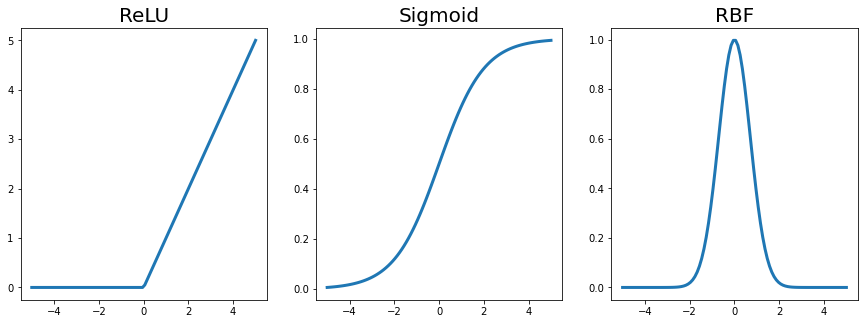

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(131)
x = np.linspace(-5,5,100)
y1 = [max(i,0) for i in x]
plt.plot(x,y1,linewidth=3)
plt.title('ReLU',fontsize=20);
plt.subplot(132)
y2 = 1/(1+np.exp(-x))
plt.plot(x,y2,linewidth=3)
plt.title('Sigmoid',fontsize=20);
plt.subplot(133)
y3 = np.exp(-x**2)
plt.plot(x,y3,linewidth=3)
plt.title('RBF',fontsize=20);

In [4]:
print('Computationally efficient' + ' '*20 + 'Smooth gradient' + ' '*20 + 'Smooth gradient')
print()
print('Dying ReLU' + ' '*34 + 'Vanishing gradient' + ' '*16 + 'Classification is slow')

Computationally efficient                    Smooth gradient                    Smooth gradient

Dying ReLU                                  Vanishing gradient                Classification is slow


Other: tanh, swish, leaky ReLU, ELU, softmax, etc. [Link](https://en.wikipedia.org/wiki/Activation_function)

[tf.keras.activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

# Feature Scaling and Data Preprocessing

## Before 

In [5]:
a = 40
np.random.seed(1)
listex = np.linspace(-a,a,100)
listey = listex**2 + 0.1*np.random.normal(0, 1, len(listex)) 

set_seed(1)
model_rbf = tf.keras.Sequential()
model_rbf.add(tf.keras.layers.Dense(5,activation=rbf))
model_rbf.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_rbf.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf.fit(listex,listey, epochs=1000, verbose=0)

# model.summary()
# model_rbf.get_weights()

set_seed(1)
model_relu = tf.keras.Sequential()
model_relu.add(tf.keras.layers.Dense(5,activation='relu'))
model_relu.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu.fit(listex,listey, epochs=1500, verbose=0)

# model_relu.get_weights()

In [6]:
preds_rbf = []
# preds = []
preds_relu = []
size = 100
for j in np.linspace(-a,a,size):
    preds_rbf.append(model_rbf.predict([j]))
#     preds.append(model.predict([j]))
    preds_relu.append(model_relu.predict([j]))

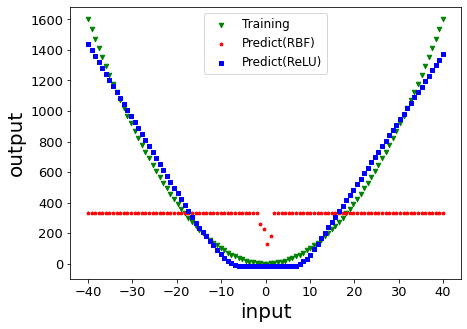

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('input',fontsize=20)
plt.ylabel("output",fontsize=20)
plt.scatter(listex, listey, s=20, marker='v',color='g', label="Training")     #size of point
plt.scatter(np.linspace(-a,a,size), np.array(preds_rbf), s=10, marker='p', color='r', label="Predict(RBF)")
# plt.scatter(np.linspace(-a,a,size), preds, s=2, label="predictions")
plt.scatter(np.linspace(-a,a,size), np.array(preds_relu), s=10, marker='s', color='blue', label="Predict(ReLU)")
plt.legend(prop={'size': 12});

## after

In [8]:
a = 40
np.random.seed(1)
listex2 = np.linspace(-1,1,200)
listey2 = ((a*listex2)**2 + 0.1*np.random.normal(0, 1, len(listex2)) )/a**2

set_seed(1)
model_rbf2 = tf.keras.Sequential()
model_rbf2.add(tf.keras.layers.Dense(5,activation=rbf))
model_rbf2.add(tf.keras.layers.Dense(1))

# model.metrics_names
model_rbf2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf2.fit(listex2,listey2, epochs=1000, verbose=0)

# model.summary()
# model_rbf2.get_weights()

set_seed(1)
model_relu2 = tf.keras.Sequential()
model_relu2.add(tf.keras.layers.Dense(5,activation='relu'))
model_relu2.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_relu2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu2.fit(listex2,listey2, epochs=1500, verbose=0)

# model_relu.get_weights()

In [9]:
preds_rbf2 = []
# preds = []
preds_relu2 = []
size = 100
x = np.linspace(-1,1,size)
for j in x:
    preds_rbf2.append(model_rbf2.predict([j]))
#     preds.append(model.predict([j]))
    preds_relu2.append(model_relu2.predict([j]))

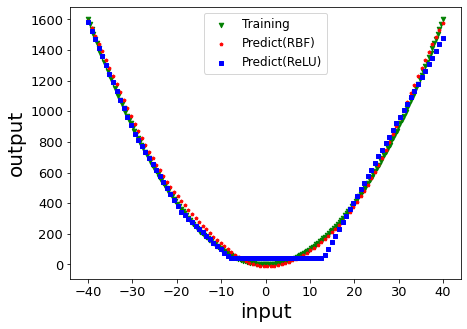

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('input',fontsize=20)
plt.ylabel("output",fontsize=20)
plt.scatter(a*listex2, a**2*listey2, s=20, marker='v',color='g', label="Training")     #size of point
plt.scatter(np.linspace(-a,a,size), a**2*np.array(preds_rbf2), s=10, marker='p', color='r', label="Predict(RBF)")
# plt.scatter(np.linspace(-a,a,size), preds, s=2, label="predictions")
plt.scatter(np.linspace(-a,a,size), a**2*np.array(preds_relu2), s=10, marker='s', color='blue', label="Predict(ReLU)")
plt.legend(prop={'size': 12});

# Neurons "ON" and "OFF"

## Target function - (1)

$$
y = x^2
$$

In [11]:
a = 40
np.random.seed(123)
listex = np.linspace(-1,1,100)
listey = listex**2 + 0.1*np.random.normal(0, 1, len(listex)) 
# listey = np.sin(np.pi*listex) + 0.1*np.random.normal(0, 1, len(listex)) 

num_neuron = 5
set_seed(123)
model_relu = tf.keras.Sequential()
model_relu.add(tf.keras.layers.Dense(num_neuron,activation='relu'))
model_relu.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu.fit(listex,listey, epochs=1500, verbose=0)

# model_relu.get_weights()

weight = model_relu.get_weights()
bdry = []
bdry1 = []
for i in range(weight[0].shape[1]):
    val = -weight[1][i]/weight[0][0,i]
    if weight[0][0,i] >0:
        bdry.append((val,i))    #bdry.append((val,i,'left'))
        bdry1.append((val,i,'left'))     # left flat
    else:
        bdry.append((val,i))    #bdry.append((val,i,'right'))
        bdry1.append((val,i,'right'))
        
bdry_arr = np.array(sorted(bdry))

def piece(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = tf.keras.activations.relu(w1*x+b1).numpy()
    return (weight[2][i])*val

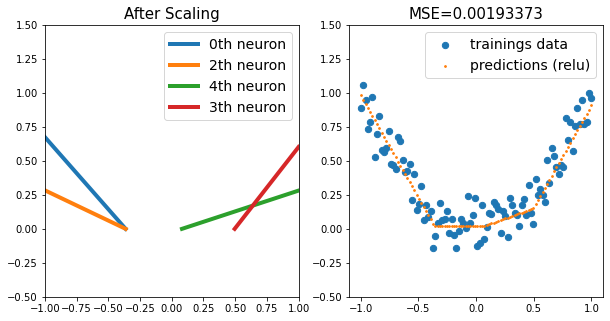

In [12]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
x_rb = 1
x_lb = -1
for i in map(int,bdry_arr[:,1]):
    if bdry1[i][-1] == 'left' and bdry1[i][0]<x_rb: #activate part is in the interval
        x = np.linspace(bdry1[i][0],x_rb,20)
        plt.plot(x, [piece(weight,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)
    elif bdry1[i][-1] == 'right' and bdry1[i][0]>x_lb:
        x = np.linspace(x_lb,bdry1[i][0],20)
        plt.plot(x, [piece(weight,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)

plt.xlim(-1,1)
plt.ylim(-0.5,1.5)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 14});
# for i in range(bdry_arr.shape[0]):
#     if bdry_arr[i,0]>=-1 and bdry_arr[i,0] <=1:
#         label = "x{:n}={:.2f}".format(bdry_arr[i,1],bdry_arr[i,0])
#         plt.text(bdry_arr[i,0],0,label)
        
plt.subplot(122)
preds_relu = []
size = 100
for j in np.linspace(-1,1,size):
#     preds_rbf.append(model_rbf.predict([j]))
#     preds.append(model.predict([j]))
    preds_relu.append(model_relu.predict([j]))
p = tf.reshape(tf.constant(preds_relu),len(preds_relu))
error = tf.keras.losses.MSE(listex**2,p).numpy()
plt.ylim(-0.5,1.5)
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.scatter(listex, listey, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_relu), s=3, label="predictions (relu)")
plt.legend(prop={'size': 14});

In [13]:
num_neuron = 5

set_seed(123)
model_rbf = tf.keras.Sequential()
model_rbf.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_rbf.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_rbf.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_rbf.fit(listex,listey, epochs=1500, verbose=0)

weight_rbf = model_rbf.get_weights()
bdry = []

for i in range(weight_rbf[0].shape[1]):
    val1 = (-2-weight_rbf[1][i])/weight_rbf[0][0,i]
    val2 = (2-weight_rbf[1][i])/weight_rbf[0][0,i]
    bdry.append((min(val1,val2),max(val1,val2)))    #bdry.append((val,i,'left'))
        
# bdry_arr = np.array(sorted(bdry))

def overlap(interval1,interval2):
    if max(interval1[0],interval2[0]) < min(interval1[1],interval2[1]):
        return [max(interval1[0],interval2[0]), min(interval1[1],interval2[1])]
    else:
        return []
    
def piece_rbf(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = rbf(w1*x+b1).numpy()
    return (weight[2][i])*val

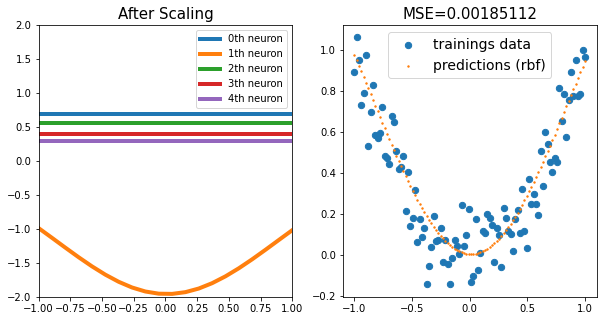

In [14]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(num_neuron):
    interval = overlap([-1,1],bdry[i])
    if len(interval)!=0:
        x = np.linspace(interval[0],interval[1],20)
        plt.plot(x, [piece_rbf(weight_rbf,i,val) for val in x], label=str(i)+'th neuron',linewidth=4)
plt.xlim(-1,1)
plt.ylim(-2,2)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 10}); 

plt.subplot(122)
preds_rbf = []
size = 100
for j in np.linspace(-1,1,size):
    preds_rbf.append(model_rbf.predict([j]))
p = tf.reshape(tf.constant(preds_rbf),len(preds_rbf))
error = tf.keras.losses.MSE(listex**2,p).numpy()
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.scatter(listex, listey, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_rbf), s=2, label="predictions (rbf)")
# plt.scatter(a*listex, a**2*listey, s=40, label="trainings data")     #size of point
# plt.scatter(np.linspace(-a,a,size), a**2*np.array(preds_rbf), s=2, label="predictions (rbf)")
# plt.ylim(-2,2)
plt.legend(prop={'size': 14});

## Target function - 2

$$
y = \sin x
$$

In [15]:
np.random.seed(123)
listex = np.linspace(-1,1,100)
# listey = listex**2 + 0.1*np.random.normal(0, 1, len(listex)) 
listey_sin = np.sin(np.pi*listex) + 0.1*np.random.normal(0, 1, len(listex)) 

In [16]:
num_neuron = 5
set_seed(32624)
model_relu_sin = tf.keras.Sequential()
model_relu_sin.add(tf.keras.layers.Dense(num_neuron,activation='relu'))
model_relu_sin.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_relu_sin.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu_sin.fit(listex,listey_sin, epochs=1500, verbose=0)

# model_relu.get_weights()

weight_sin = model_relu_sin.get_weights()
bdry_sin = []
bdry1_sin = []
for i in range(weight_sin[0].shape[1]):
    val = -weight_sin[1][i]/weight_sin[0][0,i]
    if weight_sin[0][0,i] >0:
        bdry_sin.append((val,i))    #bdry.append((val,i,'left'))
        bdry1_sin.append((val,i,'left'))     # left flat
    else:
        bdry_sin.append((val,i))    #bdry.append((val,i,'right'))
        bdry1_sin.append((val,i,'right'))
        
bdry_arr_sin = np.array(sorted(bdry_sin))

def piece(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = tf.keras.activations.relu(w1*x+b1).numpy()
    return (weight[2][i])*val

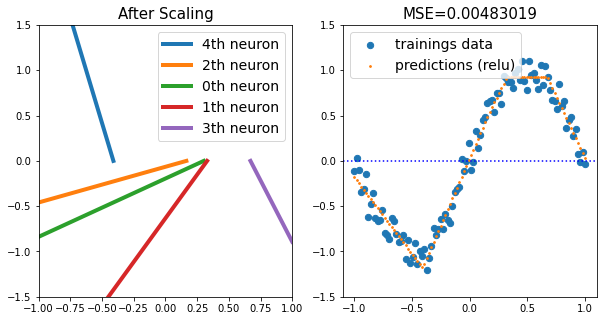

In [17]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
x_rb = 1
x_lb = -1
for i in map(int,bdry_arr_sin[:,1]):
    if bdry1_sin[i][-1] == 'left' and bdry1_sin[i][0]<x_rb: #activate part is in the interval
        x = np.linspace(bdry1_sin[i][0],x_rb,20)
        plt.plot(x, [piece(weight_sin,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)
    elif bdry1_sin[i][-1] == 'right' and bdry1_sin[i][0]>x_lb:
        x = np.linspace(x_lb,bdry1_sin[i][0],20)
        plt.plot(x, [piece(weight_sin,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)

plt.xlim(-1,1)
plt.ylim(-1.5,1.5)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 14});


plt.subplot(122)
preds_relu_sin = []
size = 100
for j in np.linspace(-1,1,size):
    preds_relu_sin.append(model_relu_sin.predict([j]))
p = tf.reshape(tf.constant(preds_relu_sin),len(preds_relu_sin))
error = tf.keras.losses.MSE(np.sin(np.pi*listex),p).numpy()
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.axhline(0,c='b',linestyle=':')
plt.ylim(-1.5,1.5)
plt.scatter(listex, listey_sin, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_relu_sin), s=3, label="predictions (relu)")
plt.legend(prop={'size': 14});

In [18]:
set_seed(123)
model_rbf_sin = tf.keras.Sequential()
model_rbf_sin.add(tf.keras.layers.Dense(2,activation=rbf))
model_rbf_sin.add(tf.keras.layers.Dense(1))
# model.metrics_names

model_rbf_sin.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_rbf_sin.fit(listex,listey_sin, epochs=1500, verbose=0)

# model_rbf.get_weights()

weight_rbf_sin = model_rbf_sin.get_weights()
bdry_sin = []

for i in range(weight_rbf_sin[0].shape[1]):
    val1 = (-2-weight_rbf_sin[1][i])/weight_rbf_sin[0][0,i]
    val2 = (2-weight_rbf_sin[1][i])/weight_rbf_sin[0][0,i]
    bdry_sin.append((min(val1,val2),max(val1,val2)))    #bdry.append((val,i,'left'))
        
# bdry_arr = np.array(sorted(bdry))

def overlap(interval1,interval2):
    if max(interval1[0],interval2[0]) < min(interval1[1],interval2[1]):
        return [max(interval1[0],interval2[0]), min(interval1[1],interval2[1])]
    else:
        return []
    
def piece_rbf(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = rbf(w1*x+b1).numpy()
    return (weight[2][i])*val

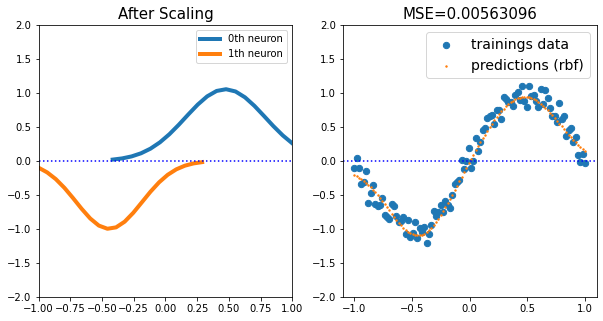

In [19]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(2):
    interval = overlap([-1,1],bdry_sin[i])
    if len(interval)!=0:
        x = np.linspace(interval[0],interval[1],20)
        plt.plot(x, [piece_rbf(weight_rbf_sin,i,val) for val in x], label=str(i)+'th neuron',linewidth=4)
plt.xlim(-1,1)
plt.ylim(-2,2)
plt.axhline(0,c='b',linestyle=':')
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 10}); 

plt.subplot(122)
preds_rbf_sin = []
size = 100
for j in np.linspace(-1,1,size):
    preds_rbf_sin.append(model_rbf_sin.predict([j]))
p = tf.reshape(tf.constant(preds_rbf_sin),len(preds_rbf_sin))
error = tf.keras.losses.MSE(np.sin(np.pi*listex),p).numpy()
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.axhline(0,c='b',linestyle=':')
plt.scatter(listex, listey_sin, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_rbf_sin), s=2, label="predictions (rbf)")
plt.ylim(-2,2)
plt.legend(prop={'size': 14});

# Architecture of the hidden layers

Some rules online:
$$
N = \frac{N_{\text{training sample size}}}{a*(N_{\text{# of input neurons}} + N_{\text{# of output neurons}})}
$$

$a\in [2,10]$

<font size="5"> Ideally, </font>

<center> 
    
    More neurons are better

    More epochs are better
</center>
    
<font size="5"> Due to </font>
- limited knowledge of the unknown model, 
- limited computing power, etc, 
     
<font size="5"> Try corss-validation.

## Target function - 1

$$
y = 
\begin{cases}
e^{x}-1 & x\leq 0,\\
\sin x & x>0.
\end{cases}
$$

In [27]:
hid_ls = np.arange(1,11)
epo_ls = 10*np.arange(1,11)

def generate_plot(coef_train, coef_test):
    score_all = np.zeros((len(hid_ls),len(epo_ls)))

    for i in range(len(hid_ls)):
        filename = '../DNN/Data/new_split_MSE0.mat'%(hid_ls[i])
        partial_data = sio.loadmat(filename)
        score_all[i] = coef_train*partial_data['train'] + coef_test*partial_data['test']    #formula to compute score
    
    fig = plt.figure(figsize=(8,5.5))
    for i in range(len(hid_ls)):
        plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
    plt.xticks(epo_ls,fontsize=13, rotation=0)
    plt.yticks(fontsize=13, rotation=0)
    plt.xlabel('Number of epochs',fontsize=20)
    plt.ylabel('MSE',fontsize=20)
    plt.legend();

In [28]:
interact(generate_plot, 
         coef_train = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Train:',),
         coef_test = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Test:',));

interactive(children=(FloatSlider(value=0.5, description='Train:', max=1.0), FloatSlider(value=0.5, descriptio…

## Target function - 2

$$
y = (x+3)(x-1)^2
$$

In [35]:
def generate_plot3(coef_train, coef_test):
    score_all = np.zeros((len(hid_ls),len(epo_ls)))

    for i in range(len(hid_ls)):
        filename = '../DNN/Data/poly_1%s1_split_MSE0.mat'%(hid_ls[i])
        partial_data = sio.loadmat(filename)
        score_all[i] = coef_train*partial_data['train'] + coef_test*partial_data['test']    #formula to compute score
    
    fig = plt.figure(figsize=(8,5.5))
    for i in range(len(hid_ls)):
        plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
    plt.xticks(epo_ls,fontsize=13, rotation=0)
    plt.yticks(fontsize=13, rotation=0)
    plt.xlabel('Number of epochs',fontsize=20)
    plt.ylabel('MSE',fontsize=20)
    plt.legend();

In [36]:
interact(generate_plot3, 
         coef_train = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Train:',),
         coef_test = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Test:',));

interactive(children=(FloatSlider(value=0.5, description='Train:', max=1.0), FloatSlider(value=0.5, descriptio…

## Target function - 3

$$
y = \sin x
$$

In [29]:
def generate_plot2(coef_train, coef_test):
    score_all = np.zeros((len(hid_ls),len(epo_ls)))

    for i in range(len(hid_ls)):
        filename = '../DNN/Data/sin_1%s1_split_MSE0.mat'%(hid_ls[i])
        partial_data = sio.loadmat(filename)
        score_all[i] = coef_train*partial_data['train'] + coef_test*partial_data['test']    #formula to compute score
    
    fig = plt.figure(figsize=(8,5.5))
    for i in range(len(hid_ls)):
        plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
    plt.xticks(epo_ls,fontsize=13, rotation=0)
    plt.yticks(fontsize=13, rotation=0)
    plt.xlabel('Number of epochs',fontsize=20)
    plt.ylabel('MSE ($y=\sin x$)',fontsize=20)
    plt.legend();

In [30]:
interact(generate_plot2, 
         coef_train = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Train:',),
         coef_test = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.1,description='Test:',));

interactive(children=(FloatSlider(value=0.5, description='Train:', max=1.0), FloatSlider(value=0.5, descriptio…

<center>
    <font size='6'> Thank You